# Разработка веб-сервиса для оценки комментариев (отзывов) к фильмам

*В рамках тестового задания для кандидатов на предстажировку Case Lab ML предлагается разработать веб-сервис для оценки комментариев (отзывов) к фильмам.*

*В текущей работе выполнена часть задания (построение моделей, которые будут предсказывать рейтинг отзыва, а также давать давать оценку отзывов к фильмам: позитивный / негативный).*  

---
**Задачи исследования:**
* провести загрузку данных
* сформировать датафреймы
* провести анализ и предобработку данных
* подготовить данные для обучения моделей
* провести обучение моделей для предсказания оценки отзыва
* провести обучение моделей для предсказания рейтинга отзыва
* для каждой из задач выбрать лучшую модель
* проверить качество моделей на тестовой выборке
* сделать общий вывод, дать рекомендации

---
**Цели исследования:**

* построить модель, которая будет давать давать оценку отзывов к фильмам: позитивный / негативный

* построить модель, которая будет предсказывать рейтинг отзыва

---
**Описание данных:**

открытый набор данных, который содержит в себе отзывы о фильмах, а также соответствующие им оценки рейтинга / рейтинг может служить ориентиром для построения модели классификации отзывов:

https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

---
**Этапы работы над проектом:**

*Шаг 1.* Загрузка данных
* загрузка данных
* создание датафреймов
* объединение датафреймов

*Шаг 2.* Изучение общей информации

*Шаг 3.* Исследовательский анализ  
* признак 'rating'
* признак 'pos_neg'
* признак 'text'

*Шаг 4.* Очистка текста + лемматизация

*Шаг 5.* Обучение моделей
* задача предсказания оценки отзыва
* задача предсказания рейтинга отзыва
* выбор лучшей модели для каждой задачи
* тестирование лучшей модели

*Шаг 5.* Общий вывод и рекомендации

In [113]:
!spacy download en_core_web_sm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 45.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [114]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import spacy
import re

from tensorflow.keras import layers
from tensorflow.keras import losses

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from tqdm import tqdm

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [116]:
RANDOM_STATE = 42

# Загрузка данных

## Загрузка данных

In [117]:
# ссылка на данные
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

In [118]:
# загрузка + распаковка данных
data = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

In [119]:
# путь к датафрейму
data_dir = os.path.join(os.path.dirname(data), 'aclImdb')

In [120]:
# список файлов в директории data_dir
os.listdir(data_dir)

['README', 'train', 'imdbEr.txt', 'imdb.vocab', 'test']

In [121]:
# путь к директории train
train_dir = os.path.join(data_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'urls_neg.txt',
 'neg',
 'pos',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_unsup.txt',
 'unsup']

In [122]:
# путь к директории test
test_dir = os.path.join(data_dir, 'test')
os.listdir(test_dir)

['urls_pos.txt', 'urls_neg.txt', 'neg', 'pos', 'labeledBow.feat']

In [123]:
# путь к директории train/pos (положительные отзывы)
train_dir_pos = os.path.join(train_dir, 'pos')

# проведем проверку // выведем один из файлов в директории train/pos
sample_file = os.path.join(train_dir, 'pos/4_8.txt')
with open(sample_file) as f:
  print(f.read())

FUTZ is the only show preserved from the experimental theatre movement in New York in the 1960s (the origins of Off Off Broadway). Though it's not for everyone, it is a genuinely brilliant, darkly funny, even more often deeply disturbing tale about love, sex, personal liberty, and revenge, a serious morality tale even more relevant now in a time when Congress wants to outlaw gay marriage by trashing our Constitution. The story is not about being gay, though -- it's about love and sex that don't conform to social norms and therefore must be removed through violence and hate. On the surface, it tells the story of a man who falls in love with a pig, but like any great fable, it's not really about animals, it's about something bigger -- stifling conformity in America.<br /><br />The stage version won international acclaim in its original production, it toured the U.S. and Europe, and with others of its kind, influenced almost all theatre that came after it. Luckily, we have preserved here 

In [124]:
# путь к директории train/neg (отрицательные отзывы)
train_dir_neg = os.path.join(train_dir, 'neg')

# проведем проверку / выведем один из файлов в директории train/neg
sample_file = os.path.join(train_dir, 'neg/4_4.txt')
with open(sample_file) as f:
  print(f.read())

This fanciful horror flick has Vincent Price playing a mad magician that realizes his vocational talents have been sold to another. He devise ways of avenging all those that have wronged him. His master scheme seems to back fire on him.<br /><br />Price is a little below par compared to his masterpieces, but is still the only reason to watch this thriller. Supporting cast includes Patrick O'Neal, Mary Murphy, Eva Gabor and Jay Novello.<br /><br />


In [125]:
# путь к директории test/pos (положительные отзывы)
test_dir_pos = os.path.join(test_dir, 'pos')

# проведем проверку / выведем один из файлов в директории test/pos
sample_file = os.path.join(test_dir, 'pos/4_10.txt')
with open(sample_file) as f:
  print(f.read())

This movie was sadly under-promoted but proved to be truly exceptional. Entering the theatre I knew nothing about the film except that a friend wanted to see it.<br /><br />I was caught off guard with the high quality of the film. I couldn't image Ashton Kutcher in a serious role, but his performance truly exemplified his character. This movie is exceptional and deserves our monetary support, unlike so many other movies. It does not come lightly for me to recommend any movie, but in this case I highly recommend that everyone see it.<br /><br />This films is Truly Exceptional!


In [126]:
# путь к директории test/neg (отрицательные отзывы)
test_dir_neg = os.path.join(test_dir, 'neg')

# проведем проверку / выведем один из файлов в директории test/neg
sample_file = os.path.join(test_dir, 'neg/4_4.txt')
with open(sample_file) as f:
  print(f.read())

Alas, another Costner movie that was an hour too long. Credible performances, but the script had no where to go and was in no hurry to get there. First we are offered an unrelated string of events few of which further the story. Will the script center on Randall and his wife? Randall and Fischer? How about Fischer and Thomas? In the end, no real front story ever develops and the characters themselves are artificially propped up by monologues from third parties. The singer explains Randall, Randall explains Fischer, on and on. Finally, long after you don't care anymore, you will learn something about the script meetings. Three endings were no doubt proffered and no one could make a decision. The end result? All three were used, one, after another, after another. If you can hang in past the 100th yawn, you'll be able to pick them out. Despite the transparent attempt to gain points with a dedication to the Coast Guard, this one should have washed out the very first day.


## Создание датафреймов

>В целях оптимизации кода для создания датафреймов будем использовать функцию ***create_df***.
>
>На входе функция принимает ссылку на директорию и бинарный признак 1/0 (положительный/отрицательный отзыв).  
>На выходе получаем датафрейм со следующими признаками:
>
>* 'id' - уникальный идентификатор отзыва  
>* 'rating' - рейтинг  
>* 'text' - текст отзыва  
>* 'pos_neg' - оценка отзыва (1 - положительный / 0 - отрицательный)

In [127]:
def create_df (dir, n):
  data = []
  for file in os.listdir(dir):
    file_path = os.path.join(dir, file)
    with open(file_path, 'r') as f:
        id, rating = file.split('_')
        text = f.read()
        data.append([id, rating, text])
  df = pd.DataFrame(data, columns=['id', 'rating', 'text'])
  df['rating'] = df['rating'].str.replace('.txt', '').astype(int)
  df['id'] = df['id'].astype(int)
  df['pos_neg'] = n
  return df

In [128]:
# создадим датафрейм с тренировочными положительными отзывами
data_train_pos = create_df(train_dir_pos, 1)
data_train_pos.head(3)

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

In [129]:
# создадим датафрейм с тренировочными отрицательными отзывами
data_train_neg = create_df(train_dir_neg, 0)
data_train_neg.head(3)

,id,rating,text,pos_neg
0,9300,1,"Spoiler Alert Well I think this movie is probably the worst film ever made. Probably in the style of Ed Wood(without the heart). The lightning is terrible. The music is very bad(piano and orgue... come on!). The acting is... well there is no acting!<br /><br />There's a guy who actually goes in the wood to search for his missing wife and take the time to have sex with a stranger.<br /><br />The killer is a fat, unscary clown who couldn't outrun a turtle!<br /><br />Every members of the cast is stupid and the director put every clichés of slashers movies in the film without effort.<br /><br />The end is so far the most stupid ever made. Think about it: The guy(ken hebert) who's acting skill is about the same as his writing(he's the brain behind this flop) invite a co-worker and two of his friends to his cabin for the week-end and kills them... On monday morning he goes back to is office like nothing happen.<br /><br />The tragedy is that Mr.Hebert try to make us beleive that it's a family affair that goes on for generation(his uncle is the clown killer)<br /><br />So of course NO cops are gonna question him after his co-worker goes missing...<br /><br />WHATEVER.<br /><br />",0
1,4271,4,"Typical thriller, has been done many times before. Simple plot outline; cop Liotta becomes obsessed with Russell's wife, and he tries to bump off good ol' Kurt so he can have her. This is beyond predictable, it doesn't even try to make you guess, the plot is the plot and there's no thinking outside the box here. I guess then the only reason to watch it is to see how it develops, but nothing is done originally or interestingly. There's not really anything to say about this film, it's not particularly bad, but there's no good points either. Russell plays Russell and you know what you're gonna get when you see him in a film. Ditto Liotta. Stowe has an annoying Cher-esque voice. I read the plot outline and I could see the film in my head, it was so obvious and basic. I watched it and it rolled out in front of my eyes exactly as I had imagined. I felt not a drop of emotion throughout. I have no feeling towards this film, it's as if I never even watched it. Considering this, it's a pretty pointless film isn't it? Still, I'll give it 3/10 for some reason.",0
2,6213,1,"This movie made it into one of my top 10 most awful movies. Horrible. <br /><br />There wasn't a continuous minute where there wasn't a fight with one monster or another. There was no chance for any character development, they were too busy running from one sword fight to another. I had no emotional attachment (except to the big bad machine that wanted to destroy them) <br /><br />Scenes were blatantly stolen from other movies, LOTR, Star Wars and Matrix. <br /><br />Examples<br /><br />>The ghost scene at the end was stolen from the final scene of the old Star Wars with Yoda, Obee One and Vader. <br /><br />>The spider machine in the beginning was exactly like Frodo being attacked by the spider in Return of the Kings. (Elijah Wood is the victim in both films) and wait......it hypnotizes (stings) its victim and wraps them up.....uh hello????<br /><br />>And the whole machine vs. humans theme WAS the Matrix..or Terminator.....<br /><br />There are more examples but why waste the time? And will someone tell me what was with the Nazi's?!?! Nazi's???? <br /><br />There was a juvenile story line rushed to a juvenile conclusion. The movie could not decide if it was a children's movie or an adult movie and wasn't much of either. <br /><br />Just awful. A real disappointment to say the least. Save your money.",0


In [130]:
# создадим датафрейм с тестовыми положительными отзывами
data_test_pos = create_df(test_dir_pos, 1)
data_test_pos.head(3)

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


In [131]:
# создадим датафрейм с тестовыми отрицательными отзывами
data_test_neg = create_df(test_dir_neg, 0)
data_test_neg.head(3)

,id,rating,text,pos_neg
0,3165,3,"This love story between an American journalist and an Eurasian lady doctor does not contain much conflict, since she is largely Westernized (having studied in London), nor any fireworks, since she behaves rather restrained. What little interest the story manages to raise is knocked down further by their wooden dialogs. They are supposed to be two cosmopolitan intellectuals, but talk as if the words are put in their mouths by a Hollywood hack who is not much of one himself. The movie also suffers from an amazing lack of realism - a completely deserted beach in crowded little Hongkong, overrun by a million Chinese refugees? And a presumably accomplished American journalist in his 40s who doesn't know what a hysterectomy is? Hollywood ideas. Finally ""the song"". After hearing it an estimated twenty times throughout the movie, starting right with the credits, it tends to loose some of its emotional impact, sorry to say.",0
1,4597,3,"After Matt Dillon's phenomenal performance in CRASH, most will probably rush to pick up a copy of FACTOTUM to see if Dillon is for real or simply got a lucky rebound from a great script.<br /><br />Well, Factotum certainly has its moments, but the plainness of ...everything will most likely turn viewers off. However nothing should be taken away from Dillon. His performance is wonderful and full of excellent deadpan humor, proving he's a solid actor with significant chops; it's just a shame about the directing and script.<br /><br />The story is about Henry ""Hank"" Chinaski (Dillon) and his refusal to conform to anything resembling normalcy. He quits or gets fired from jobs in mere minutes, only to find himself back in a dreary pub meeting even drearier women while trying to write a nonconformist novel. We never really know what the novel is about except that it involves ""everything"" (cancer, movies, you, me).<br /><br />Skipping from workplace to workplace and constantly returning to Jan (Lili Taylor, THE HAUNTING), a loser girlfriend who's just as dispiriting as himself, Hank tries vainly to discover what his life is supposed to hold for him. Whether he ever learns what that is is up for interpretation. Some may say that he never does, while others might argue that his life is simply a path to obscurity.<br /><br />Regardless, there's not much substance to Factotum even with Matt Dillon's fine performance. The story meanders through Hank's life without much thought given as to where to take the audience. And that's a shame. Dillon's performance would've shone even brighter if given a decent script.",0
2,9979,4,"""Caligula"" shares many of the same attributes as the 1970 ""Fellini Satyricon"" with bizarre sights, freakishness, and depictions of sexual excesses all set in the ""glory"" of ancient Rome. But Fellini it ain't... First of all it is not as entertaining. Far too much screen time is devoted to bug-eyed, rubber-faced McDowell in the titular role. His performance is far too fey and campy to be convincing. The portrayals by Jay Robinson in ""The Robe"" (1953) and David Cain-Haughton in ""Emperor Caligula"" (1983) are far more persuasive and believable, with the latter being the most nuanced. Relief could have been judiciously provided by developing the surrounding characters more fully. As it is, they are little more than cyphers. One example is the role of Macro, played by Guido Mannari who has tremendous screen presence in an important role, but is mostly left in the background. The only positive features to credit are the adroit use of some Prokofiev and Stravinsky themes in the music score and the inclusion of some of the distasteful but nevertheless accurate actions of the despot. These two factors are far less than what is needed to relieve the prevailing tedium, however.",0


## Объединение датафреймов

* Датафреймы data_train_pos и data_train_neg объединим в один датафрейм data_train

In [132]:
data_train = pd.concat([data_train_pos, data_train_neg], axis=0).reset_index(drop=True)
data_train.head(3)

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

* Датафреймы data_test_pos и data_test_neg объединим в один датафрейм data_test

In [133]:
data_test = pd.concat([data_test_pos, data_test_neg], axis=0).reset_index(drop=True)
data_test.head(3)

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


---
**ВЫВОД ПО БЛОКУ 'ЗАГРУЗКА ДАННЫХ'**

Итак, загрузка данных произведена успешно.  
В результате были получены датафреймы data_test и data_train.

Далее будем работать с датафреймами data_test и data_train.

# Изучение общей информации

>В целях оптимизации кода для получения информации о каждом датафрейме создадим функцию ***check_df***:

In [134]:
def check_df(df):
  print('Первые 3 строки датафрейма:')
  display(df.head(3))
  print('-----------------------------------------------------------------------------------------------------------------------')
  print('Общая информация о датафрейме:')
  display(df.info())
  print('-----------------------------------------------------------------------------------------------------------------------')
  print('Описание датафрейма:')
  display(df.info())
  print('-----------------------------------------------------------------------------------------------------------------------')
  print('Наименования столбцов:', df.columns)
  print('-----------------------------------------------------------------------------------------------------------------------')
  print(f'Количество дубликатов:', {df.duplicated().sum()})
  print('-----------------------------------------------------------------------------------------------------------------------')
  print('Количество пропусков:', df.isna().sum())

## Датафрейм data_test

In [135]:
check_df(data_test)

Первые 3 строки датафрейма:


,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


-----------------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


None

-----------------------------------------------------------------------------------------------------------------------
Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


None

-----------------------------------------------------------------------------------------------------------------------
Наименования столбцов: Index(['id', 'rating', 'text', 'pos_neg'], dtype='object')
-----------------------------------------------------------------------------------------------------------------------
Количество дубликатов: {0}
-----------------------------------------------------------------------------------------------------------------------
Количество пропусков: id         0
rating     0
text       0
pos_neg    0
dtype: int64


## Датафрейм data_train

In [136]:
check_df(data_train)

Первые 3 строки датафрейма:


,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

-----------------------------------------------------------------------------------------------------------------------
Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


None

-----------------------------------------------------------------------------------------------------------------------
Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25000 non-null  int64 
 1   rating   25000 non-null  int64 
 2   text     25000 non-null  object
 3   pos_neg  25000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 781.4+ KB


None

-----------------------------------------------------------------------------------------------------------------------
Наименования столбцов: Index(['id', 'rating', 'text', 'pos_neg'], dtype='object')
-----------------------------------------------------------------------------------------------------------------------
Количество дубликатов: {0}
-----------------------------------------------------------------------------------------------------------------------
Количество пропусков: id         0
rating     0
text       0
pos_neg    0
dtype: int64


---
**ВЫВОД ПО БЛОКУ 'ИЗУЧЕНИЕ ОБЩЕЙ ИНФОРМАЦИИ'**

Мы изучили общую информацию о датафреймах data_train и data_test.

В каждом их датафреймов содержится: 25 000 строк / 4 столбца ('id', 'rating', 'text', 'pos_neg').  
Названия столбцов соответствуют 'змеиному стилю'.  
Тип данных корректный во всех столбцах.  
Пропусков и дубликатов в данных нет.  

# Исследовательский анализ данных

>В целях оптимизации кода для построения графиков создадим функцию ***graphs_cat***:

In [137]:
def graphs_cat (df, feature):

    palette = sns.color_palette("tab10", len(df))
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    df.groupby(feature)[feature].count().sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Столбчатая диаграмма: {feature}', fontsize=15)
    plt.xticks(rotation=0)
    plt.xlabel(f'{feature}', fontsize=14)
    plt.ylabel('количество', fontsize=14)

    plt.subplot(1, 2, 2)
    plt.title(f'Круговая диаграмма: {feature}', fontsize=15)
    df.groupby(feature)[feature].count().sort_values(ascending=False).plot(
                                    kind='pie',
                                    colors=palette,
                                    autopct='%1.1f%%',
                                    subplots=True)
    plt.show()

>В целях оптимизации кода для построения графиков создадим функцию ***graphs_col***:

In [138]:
def graphs_col (df, feature, number_bins):

    plt.figure(figsize=(20, 12))

    plt.subplot(2, 1, 1)
    plt.hist(df[feature], edgecolor='black', bins=number_bins)
    plt.title(f'Распределение признака {feature}', fontsize=15)
    plt.ylabel('плотность распределения', fontsize=14)
    plt.xlabel(f'{feature}', fontsize=14)

    plt.subplot(2, 1, 2)
    df.boxplot(column=feature, fontsize=14, vert=False)
    plt.title(f'Диаграмма размаха для параметра {feature}', fontsize=15)
    plt.ylabel(f'{feature}', fontsize=14)
    plt.show()

## Признак 'rating'

### data_test / признак 'rating'

In [139]:
data_test['rating'].describe()

,rating
count,25000.000000
mean,5.512960
std,3.490902
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


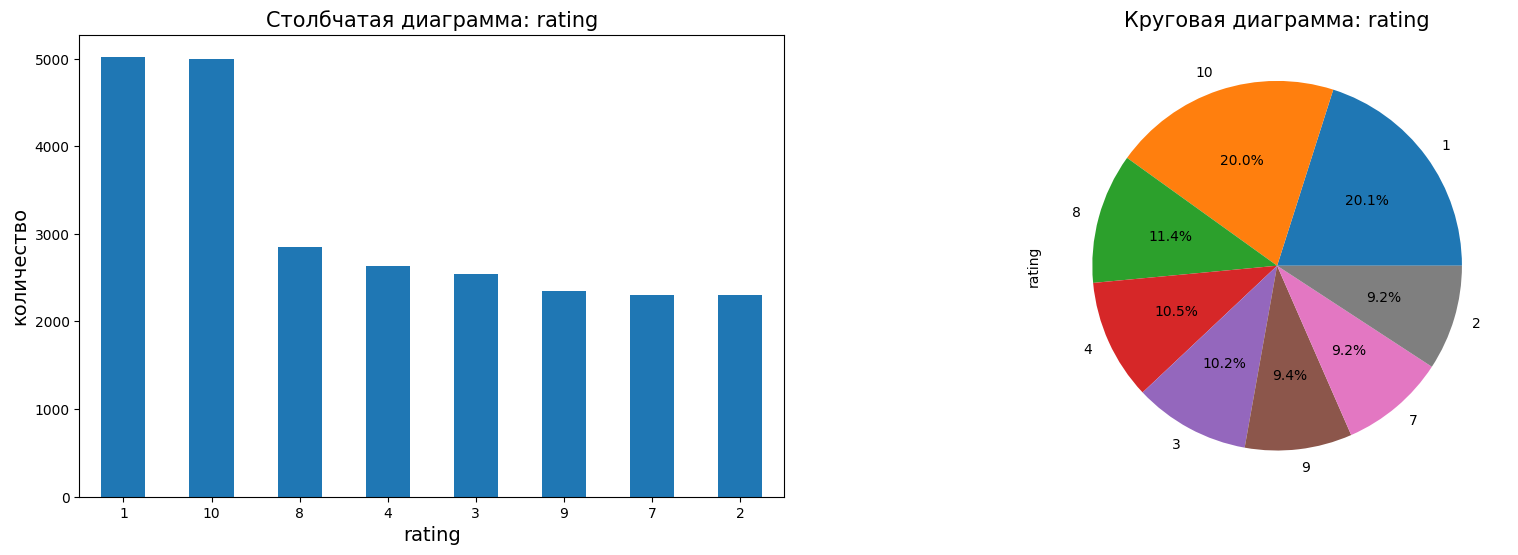

In [140]:
graphs_cat (data_test, 'rating')

### data_train / признак 'rating'

In [141]:
data_train['rating'].describe()

,rating
count,25000.000000
mean,5.477720
std,3.466477
min,1.000000
25%,2.000000
50%,5.500000
75%,9.000000
max,10.000000


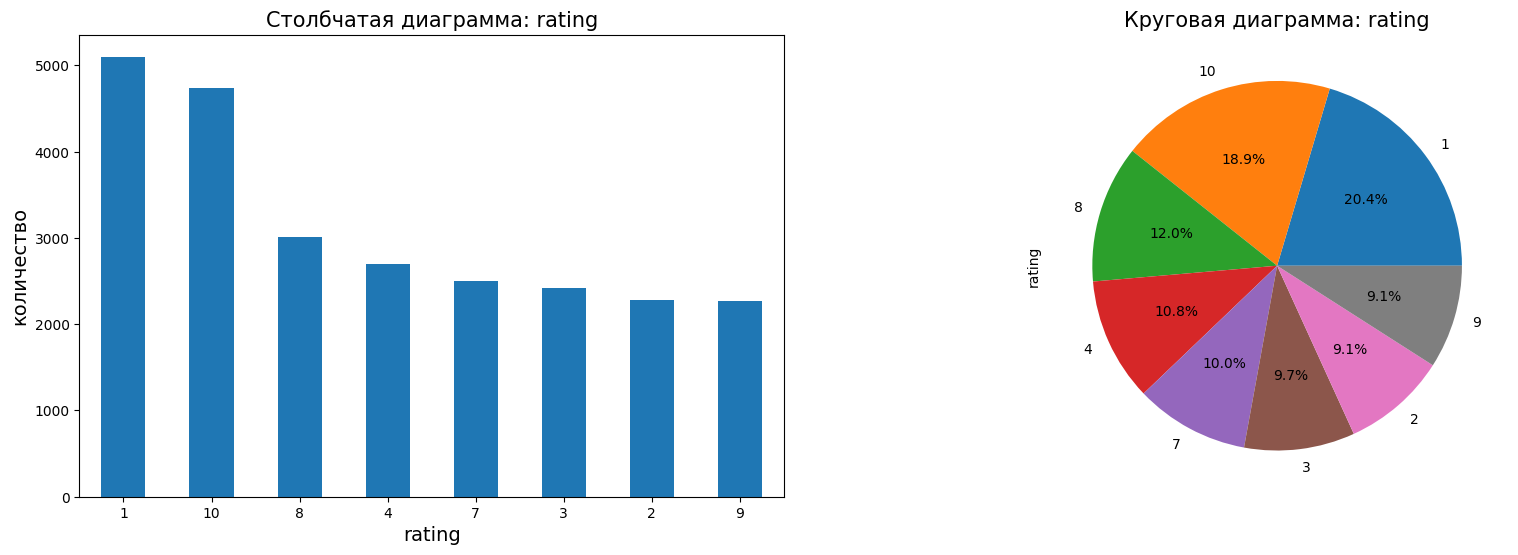

In [142]:
graphs_cat (data_train, 'rating')

---
Отметим, что преобладают крайние значения оценок: 1 (фильм совсем не понравился) и 10 (фильм очень понравился).  
Также существует некоторый дисбаланс классов - количество оценок с рейтингом 1 и 10 значительно больше, чем остальных.

## Признак 'pos_neg'

### data_test / признак 'pos_neg\'

In [143]:
data_test['pos_neg'].describe()

,pos_neg
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


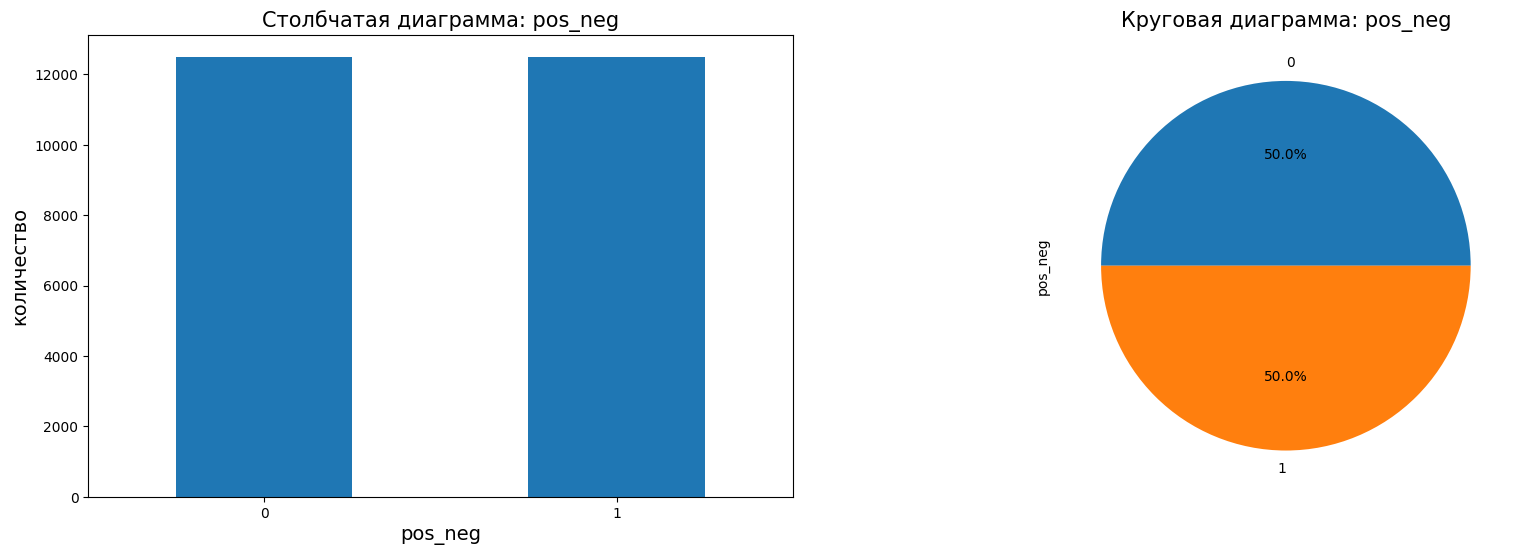

In [144]:
graphs_cat (data_test, 'pos_neg')

### data_train / признак 'pos_neg'

In [145]:
data_train['pos_neg'].describe()

,pos_neg
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


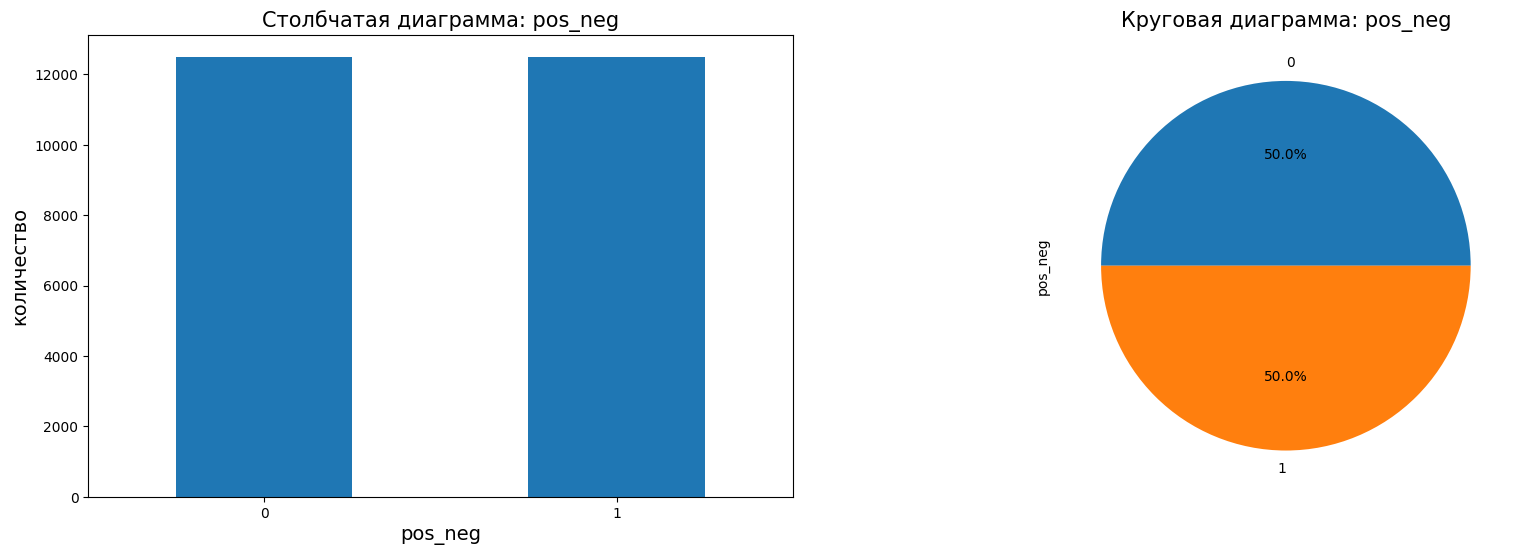

In [146]:
graphs_cat (data_train, 'pos_neg')

---
Признак 'pos_neg' содержит уникальные значения '0' и '1'.  
Дисбаланса классов нет.

## Признак 'text'

### data_test / признак 'text'

In [147]:
data_test.head(3)

,id,rating,text,pos_neg
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1


Отметим, что комментарии на английском языке, в разном регистре, присутствуют неиформативные символы.  
Очистку от ненужных символов, а также все преобразования с текстом произведем на следующем этапе.

Добавим в датафрейм data_test новый признак 'len' (длина комментария).

In [148]:
# добавим столбец 'len' для расчета длины комментариев
data_test['len'] = data_test['text'].apply(len)

In [149]:
data_test.head(3)

,id,rating,text,pos_neg,len
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1,941
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1,505
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both company names on the opening credits. This is a superior haunted house thriller equally as scary as both The Innocents and The Haunting made 8 years later. Really chilling and very creepy, this tiny film is exactly the sort of really good film Ida Lupino made and was responsible for. Try and find it...you will always remember it and as I feel, much admiration for this great and almost forgotten actress/producer.",1,1549


Пострим график распределения и диаграмму размаха для признака 'len'.

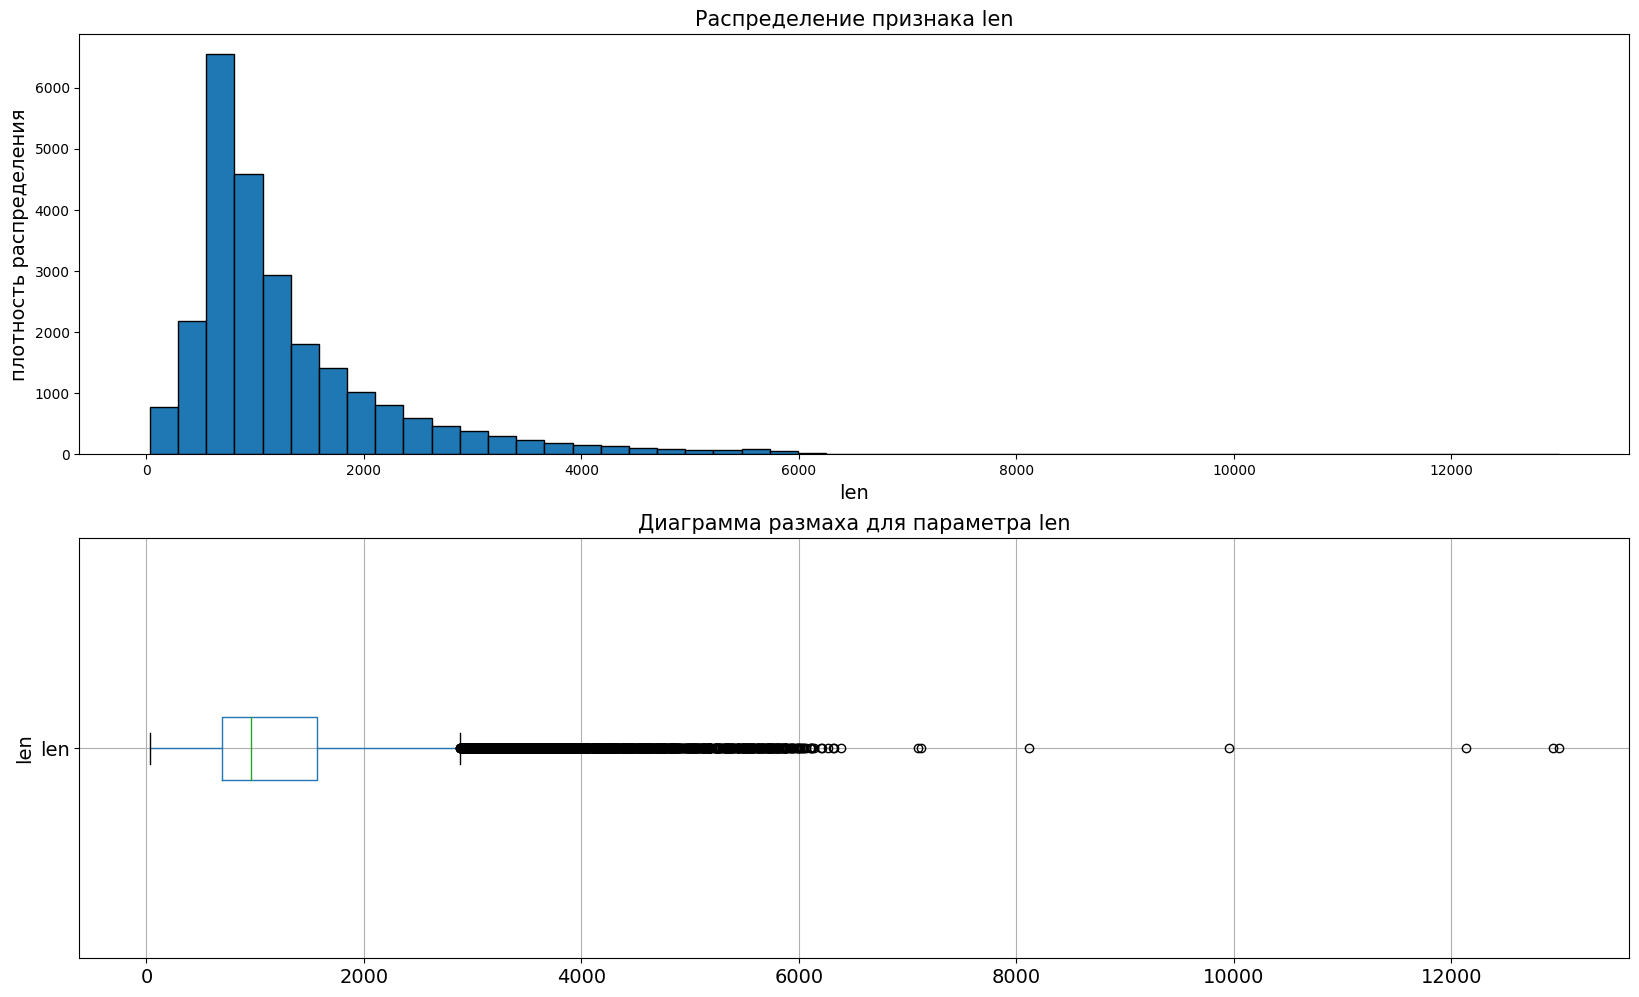

In [150]:
graphs_col (data_test, 'len', 50)

Рассматрим аномалии - самые длинные и самые короткие комментарии.

In [151]:
data_test['len'].describe()

,len
count,25000.00000
mean,1293.79240
std,975.90776
min,32.00000
25%,696.00000
50%,962.00000
75%,1572.00000
max,12988.00000


Отметим, что самый длинный комментарий в датасете data_test состоит из 12 988 символов, а самый короткий - из 32.

In [152]:
# рассматрим более подробно самые длинные комментарии
data_test.sort_values(by='len').tail()

id  rating  \
9768  3958       9   
9563   754       9   
8663  4051      10   
8065  3801       7   
6297  8647      10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [153]:
# рассматрим более подробно самые короткие комментарии
data_test.sort_values(by='len').head()

,id,rating,text,pos_neg,len
24424,6850,2,"Read the book, forget the movie!",0,32
22674,7035,2,"What a script, what a story, what a mess!",0,41
18381,321,1,I hope this group of film-makers never re-unites.,0,49
22650,5147,1,Primary plot!Primary direction!Poor interpretation.,0,51
24985,8621,2,"More suspenseful, more subtle, much, much more disturbing....",0,61


Таким образом, можно сделать следующий вывод: так называемые "выбросы" - аномалии, которые мы видим на диаграмме размаха - это действительно реальные комментарии (удалять их не будем).

Выясним, есть ли зависимость между длиной комментария и его оценкой (позитивный / негативный комментарий).

In [154]:
# сделаем срезы по позитивным и негативным комментариям
pos_test = data_test.query('pos_neg == 1')
neg_test = data_test.query('pos_neg == 0')

In [155]:
print('Количество позитивных комментариев:', len(pos_test))
print('Количество негативных комментариев:', len(neg_test))

Количество позитивных комментариев: 12500
Количество негативных комментариев: 12500


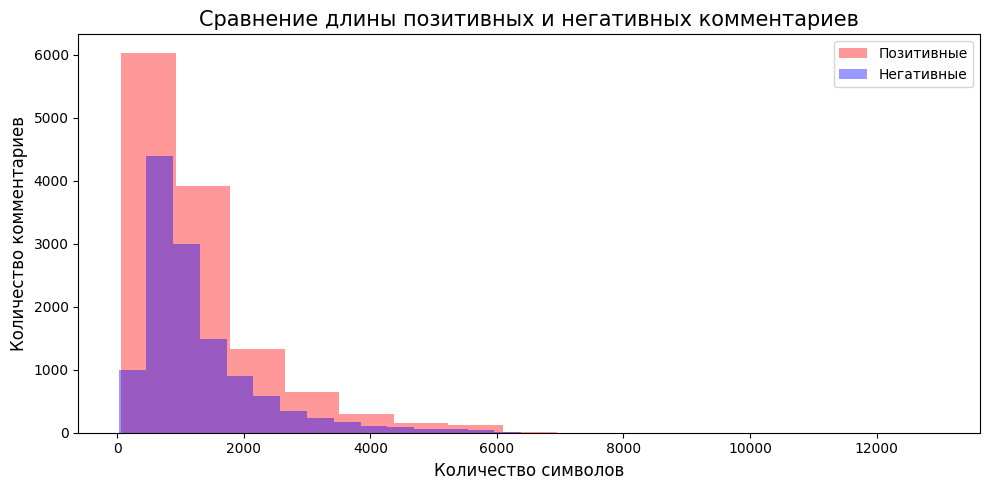

In [156]:
# наложим графики друг на друга
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(pos_test['len'], bins=15, alpha=0.4, label='Позитивные', color='red')
ax.hist(neg_test['len'], bins=15, alpha=0.4, label='Негативные', color='blue')

ax.set_title('Сравнение длины позитивных и негативных комментариев', fontsize=15)
ax.set_xlabel('Количество символов', fontsize=12)
ax.set_ylabel('Количество комментариев', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

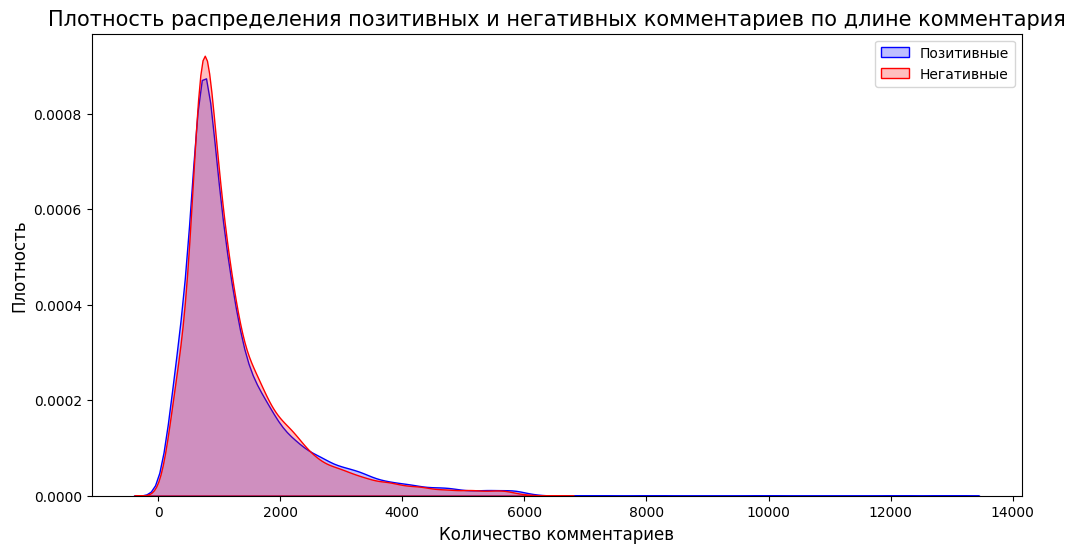

In [157]:
# график плотности распределения комментариев по длине сообщения
plt.figure(figsize=(12, 6))

sns.kdeplot(pos_test['len'], fill=True, color='blue', label='Позитивные')
sns.kdeplot(neg_test['len'], fill=True, color='red', label='Негативные')

plt.title('Плотность распределения позитивных и негативных комментариев по длине комментария', fontsize=15)
plt.xlabel('Количество комментариев', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.show()

Из графика можем сделать вывод, что длина отзыва не зависит от его оценки.

### data_train / признак 'text'

In [158]:
data_train.head(3)

,id,rating,text,pos_neg
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in the warn

---
Отметим, что комментарии на английском языке, в разном регистре, присутствуют неиформативные символы.  
Очистку от ненужных символов, а также все преобразования с текстом произведем на следующем этапе.

Добавим в датафрейм data_test новый признак 'len' (длина комментария).

In [159]:
# добавим столбец 'len' для расчета длины комментариев
data_train['len'] = data_train['text'].apply(len)

In [160]:
data_train.head(3)

,id,rating,text,pos_neg,len
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1,2981
1,3803,9,"What people fail to understand about this movie is that it isn't a beginning, middle, and end, it is just the conclusion of a 26 episode long TV series. So remember that when you all talk about how the world wasn't explored enough. That was all done in the TV show.<br /><br />As great and stunning as the visuals are, I think the ***SPOILERS*** argument between Lian-Chu and Gwizdo near the end of the film was what really made me love this movie. Seeing characters I had followed through 26 episodes fight like that was agonizing, and seeing Gwizdo walking sadly off by himself amidst the floating ruins while Lian-Chu sharpened his blade was almost tear-jerking. <br /><br />Then we got a total contrast with Lian-Chu fighting these insanely awesome dragons (Which had been featured before in the series) while Gwizdo is babbling insanely and indirectly threatening to kill Zoe. *Shudder* I'm surprised that this particular scene hasn't been mentioned more in

Пострим график распределения и диаграмму размаха для признака 'len'.

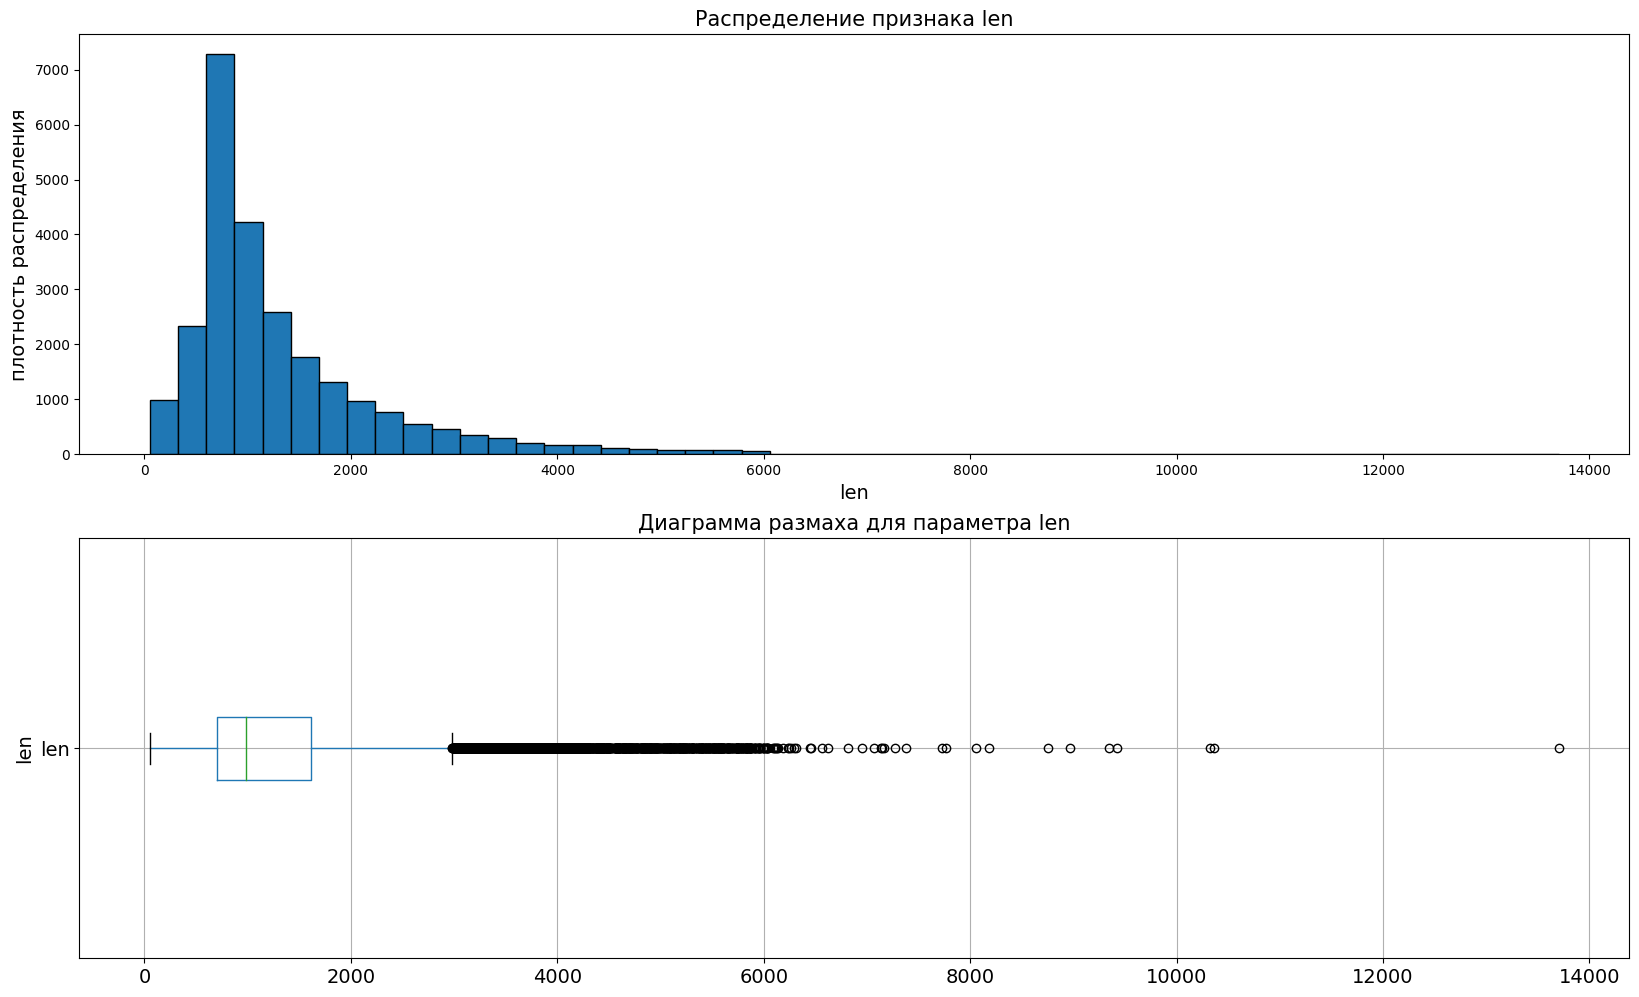

In [161]:
graphs_col (data_train, 'len', 50)

Рассматрим аномалии - самые длинные и самые короткие комментарии.

In [162]:
data_train['len'].describe()

,len
count,25000.00000
mean,1325.06964
std,1003.13367
min,52.00000
25%,702.00000
50%,979.00000
75%,1614.00000
max,13704.00000


Отметим, что самый длинный комментарий в датасете data_train состоит из 13 704 символов, а самый короткий - из 52.

In [163]:
# рассматрим более подробно самые длинные комментарии
data_train.sort_values(by='len').tail()

id  rating  \
12369   2662      10   
164     4076      10   
2725   10044       9   
9120    4383       9   
874     1175       9   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [164]:
# рассматрим более подробно самые короткие комментарии
data_train.sort_values(by='len').head()

,id,rating,text,pos_neg,len
21709,10962,3,This movie is terrible but it has some good effects.,0,52
13632,2331,1,I wouldn't rent this one even on dollar rental night.,0,53
24561,12077,1,Ming The Merciless does a little Bardwork and a movie most foul!,0,64
19714,266,3,You'd better choose Paul Verhoeven's even if you have watched it.,0,65
7616,4518,9,Adrian Pasdar is excellent is this film. He makes a fascinating woman.,1,70


Таким образом, можно сделать следующий вывод: так называемые "выбросы" - аномалии, которые мы видим на диаграмме размаха - это действительно реальные комментарии (удалять их не будем).

Выясним, есть ли зависимость между длиной комментария и его оценкой (позитивный / негативный комментарий).

In [165]:
# сделаем срезы по позитивным и негативным комментариям
pos_train = data_train.query('pos_neg == 1')
neg_train = data_train.query('pos_neg == 0')

In [166]:
print('Количество позитивных комментариев:', len(pos_train))
print('Количество негативных комментариев:', len(neg_train))

Количество позитивных комментариев: 12500
Количество негативных комментариев: 12500


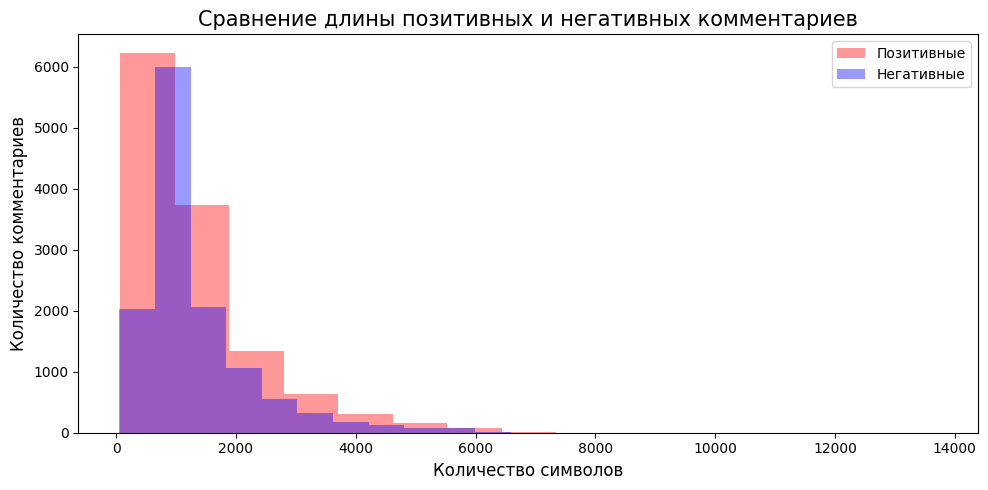

In [167]:
# наложим графики друг на друга
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(pos_train['len'], bins=15, alpha=0.4, label='Позитивные', color='red')
ax.hist(neg_train['len'], bins=15, alpha=0.4, label='Негативные', color='blue')

ax.set_title('Сравнение длины позитивных и негативных комментариев', fontsize=15)
ax.set_xlabel('Количество символов', fontsize=12)
ax.set_ylabel('Количество комментариев', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

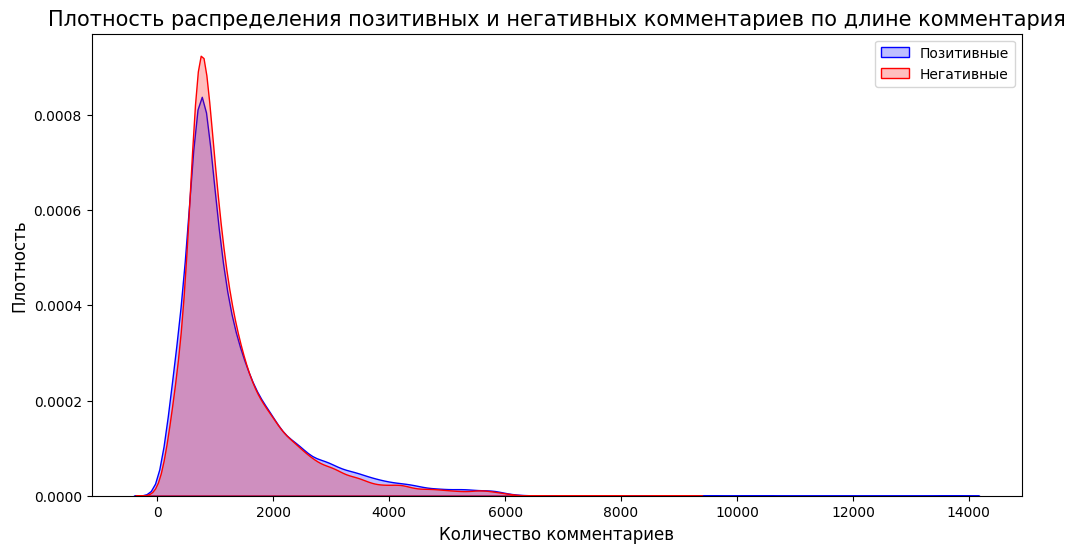

In [168]:
# график плотности распределения комментариев по длине сообщения
plt.figure(figsize=(12, 6))

sns.kdeplot(pos_train['len'], fill=True, color='blue', label='Позитивные')
sns.kdeplot(neg_train['len'], fill=True, color='red', label='Негативные')

plt.title('Плотность распределения позитивных и негативных комментариев по длине комментария', fontsize=15)
plt.xlabel('Количество комментариев', fontsize=12)
plt.ylabel('Плотность', fontsize=12)
plt.legend()
plt.show()

Из графика можем сделать вывод, что длина отзыва не зависит от его оценки.

---
Мы провели ананиз признака 'text' в датафреймах data_test и data_train.

Отметим, что все комментарии на английском языке, в разном регистре, присутствуют неиформативные символы (*все преобразования с текстом произведем на следующем этапе*).

В данные был добавлен новый признак 'len' (длина комментария).

В данных есть аномально длинные и аномально короткие комментарии (самые длинные комментарии - 12 988 и 13 704 символов, самые короткие - 32 и 52 символов в датасетах data_test и data_train соответственно).

Так называемые "выбросы", которые мы видим на диаграмме размаха - это реальные комментарии (удалять их не будем).

Также было выявлено, что длина отзыва не зависит от его оценки.


---
**ВЫВОД ПО БЛОКУ 'ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ'**

Итак, мы провели исследовательский анализ датафреймов data_test и data_train.

* **признак 'rating'**

Было выявлено, что преобладают крайние значения оценок: 1 (фильм совсем не понравился) и 10 (фильм очень понравился).
Также существует некоторый дисбаланс классов - количество оценок с рейтингом 1 и 10 значительно больше, чем остальных.

* **признак 'pos_neg'**

Признак 'pos_neg' содержит уникальные значения '0' и '1'.
Дисбаланса классов нет.

* **признак 'text'**

Отметим, что все комментарии на английском языке, в разном регистре, присутствуют неиформативные символы (*все преобразования с текстом произведем на следующем этапе*).

В данные был добавлен новый признак 'len' (длина комментария).

В данных есть аномально длинные и аномально короткие комментарии (самые длинные комментарии - 12 988 и 13 704 символов, самые короткие - 32 и 52 символов в датасетах data_test и data_train соответственно).

Так называемые "выбросы", которые мы видим на диаграмме размаха - это реальные комментарии (удалять их не будем).

Также было выявлено, что длина отзыва не зависит от его оценки.

# Очистка текста + лемматизация

На этом этапе очистим текст от ненужных символов, проведем лемматизацию с помощью WordNetLemmatizer.

In [169]:
# для лемматизации слов в тексте на английском языке инициализируем WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

>Для pos-тегов - маркировки частей речи создадим функцию ***get_wordnet_pos***:

In [170]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

>Для для очистки и лемматизации текста с маркированными частями речи создадим функцию ***clear_text***:

In [171]:
def clear_text(text):
    text = text.lower()
    reg = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = reg.split()
    lemm = []
    # в цикле лемматизируем очищенный текст
    for i in range(len(clear)):
      lemm.append(lemmatizer.lemmatize(clear[i], get_wordnet_pos(clear[i])))
    return " ".join(lemm)

In [172]:
# добавим новый столбец с лемматизированным текстом в датафрейм data_test_len
# статус выполнения операции будем отслеживать с помощью прогресс-бара от tqdm
tqdm.pandas()
data_test['lemm_text'] = data_test['text'].progress_apply(clear_text)

100%|██████████| 25000/25000 [13:43<00:00, 30.35it/s]


In [173]:
# добавим новый столбец с лемматизированным текстом в датафрейм data_train_len
# статус выполнения операции будем отслеживать с помощью прогресс-бара от tqdm
tqdm.pandas()
data_train['lemm_text'] = data_train['text'].progress_apply(clear_text)

100%|██████████| 25000/25000 [13:47<00:00, 30.22it/s]


In [174]:
data_test.head(3)

,id,rating,text,pos_neg,len,lemm_text
0,1753,7,Hoppity is a charming if slightly phycadelic animated movie that considering it was made in the 1941 has stood the test of time incredibly well. Now I have to admit I have a soft spot for 'HoppityGoes To Town' (as it is called in the United Kingdom) having watched a VHS version taped of the TV by our parents many times with my siblings.Imagine my surprise when I woke up this morning just in time to catch it on Channel Four (at 0615 never the less!) The film was just as delightful as I remembered it with the animation standing the test of time and a lovely moral tale which should appeal to parents and children alike. Maybe one day I to shall share this forgotten classic with children of my own. With a nice running time for kids (88 Min's)and a simple yet involving storyline there really is something for everyone in this tale of the little guy coming good. I really could see this being successfully remade in CGI. Take note Pixar.,1,941,hoppity be a charm if slightly phycadelic animate movie that consider it be make in the have stood the test of time incredibly well now i have to admit i have a soft spot for hoppitygoes to town a it be call in the united kingdom have watch a vhs version taped of the tv by our parent many time with my sibling imagine my surprise when i woke up this morning just in time to catch it on channel four at never the less the film be just a delightful a i remember it with the animation stand the test of time and a lovely moral tale which should appeal to parent and child alike maybe one day i to shall share this forgotten classic with child of my own with a nice run time for kid min s and a simple yet involve storyline there really be something for everyone in this tale of the little guy come good i really could see this be successfully remade in cgi take note pixar
1,6277,10,"To be frank, this is probably the best version in my book as a sound movie version of the Jazz Singer. The 1927 version is really a silent movie despite its build-up as the first talkie.<br /><br />Danny Thomas is a great comedian, and he sings very well. He does the Jewish stuff with feeling. Peggy Lee is great and any film that has her is always entertaining. Allan Joslyn is not too entertaining and we could have done without him. One question: since when do Cantors live in such luxurious houses???",1,505,to be frank this be probably the best version in my book a a sound movie version of the jazz singer the version be really a silent movie despite it build up a the first talkie br br danny thomas be a great comedian and he sings very well he do the jewish stuff with feel peggy lee be great and any film that have her be always entertain allan joslyn be not too entertain and we could have do without him one question since when do cantor live in such luxurious house
2,4966,7,"I wish I could have met Ida Lupino. When people ask who you if you could have 6 extraordinary 20th century persons over for dinner, well, for me one person would be her. I think she is now one of the great unsung and unprofiled personalities in the film industry. Her life story would make a great tele movie (Hey, Mr Bogdanovich........). Ida Lupino has been the driving force in many fascinating noir films of the 40s and 50s. I can remember being saddened at seeing her reduced to a horrible part in a ghastly AIP film is the late 70s. She was bitten by a big worm at the kitchen sink. Ugh. I should have contacted her then as she died not long after.. more from the part than the worm too. From High Sierra, Roadhouse and the extraordinary RKO thriller On Dangerous Ground, Ida Lupino was often the producer and the lead actress. Later, with her husband Howard Duff they produced many now timeless noir dramas that are still very engrossing today. One of them is JENNIFER which I think is the last film with a Monogram Pictures copyright. Monogram changed the company name formally to Allied Artists in 1953 and JENNIFER has both

In [175]:
data_train.head(3)

,id,rating,text,pos_neg,len,lemm_text
0,8252,9,"A year or so ago, I was watching the TV news when a story was broadcast about a zombie movie being filmed in my area. Since then I have paid particular attention to this movie called 'Fido' as it finished production and began playing at festivals. Two weeks ago Fido began playing in my local theater. And, just yesterday, I read a newspaper article which stated Fido is not attracting audiences in it's limited release, with the exception of our local theater. In fact, here it is outdrawing all other shows at The Paramount Theater, including 300. Of course, this makes sense as many locals want to see their city on screen or spot themselves roaming around in zombie make-up. And for any other locals who haven't seen Fido yet but are considering it, I can say there are many images on screen, from the school to city park to the forbidden zone, that you will recognize. In fact, they make the Okanagan Valley look beautiful. That's right beautiful scenery in a zombie movie! However, Fido itself is a very good movie. Yes, despite its flaws, it is better then most of the 20 other movies playing in my local market. Fido is best described as an episode of Lassie in which the collie has been replaced by a member of the undead. This is a clever premise. And the movie even goes further by taking advantage of the 1950's emphasize on conformity and playing up the cold-war paranoia which led to McCarthyism. Furthermore, it builds on the notion that zombies can be tamed or trained which George Romero first introduced in Day Of The Dead.<br /><br />K'Sun Ray plays a small town boy who's mother (Carrie-Ann Moss) longs for a zombie servant so she can be like all the other house wives on her block. However, his dad (Dylan Baker) is against the idea as he once had to kill his own 'zombie father'. Eventually, the family does acquire a zombie named 'Fido' (played by Billy Connolly), and adjusts to life with the undead. Billy Connolly was inspired casting. He is able to convey Fido's confusion, longing, hatred, and loyalty through only his eyes, lumbering body, and grunts. Connolly shows that he can play understated characters better than his outrageously comedic ones. This is his best role since Mrs. Brown.<br /><br />Fido follows in the footsteps of other recent zomcoms such as Shawn Of The Dead and Zombie Honeymoon. Being someone who appreciates Bruce Campbell and Misty Mundae movies more than Eli Roth and Jigsaw ones, I prefer humor over gore in my horror. However, I understand the criticism of those horror fans who feel there is not enough 'undead carnage' in Fido. Yet, I am sure patient viewers will be rewarded by the films gentle humor.<br /><br />The movie does break down in it's third act. It's as if the writers were so wrapped up in the cute premise of domesticated zombies in the 1950s, they forgot about the story arc. However, given my interest in horror comedies and my appreciation for seeing the neighborhood on screen, I rate Fido 9 out of 10.",1,2981,a year or so ago i be watch the tv news when a story be broadcast about a zombie movie be film in my area since then i have paid particular attention to this movie call fido a it finish production and begin play at festival two week ago fido begin play in my local theater and just yesterday i read a newspaper article which state fido be not attract audience in it s limited release with the exception of our local theater in fact here it be outdraw all other show at the paramount theater include of course this make sense a many local want to see their city on screen or spot themselves roam around in zombie make up and for any other local who haven t see fido yet but be consider it i can say there be many image on screen from the school to city park to the forbidden zone that you will recognize in fact they make the okanagan valley look beautiful that s right beautiful scenery in a zombie movie however fido itself be a very good movie yes despite it f

Итак, мы очистили датасет от ненужных символов, разметили части речи и привели слова к начальным формам.  
Лемматизированный текст находится в столбце 'lemmatized_text'.

Далее построим мешок слов по классам, для каждого класса определим наиболее характерные слова

In [176]:
# найдём стоп-слова (слова без смысловой нагрузки)
stop_words = list(nltk_stopwords.words('english'))
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [177]:
# ограничим количество уникальных слов, которые будут включены в итоговую матрицу - 20
# исключим из анализа набор стоп-слов stop_words
count_vect = CountVectorizer(max_features=20, stop_words=stop_words)

Построим мешок слов для позитивных и негативных комментариев  
* датасет data_test

In [178]:
# сделаем срезы по позитивным и негативным комментариям
pos = data_test.query('pos_neg == 1')
neg = data_test.query('pos_neg == 0')

In [179]:
corpus_pos = list(pos['lemm_text'])
bow_pos = count_vect.fit_transform(corpus_pos)

In [180]:
# словарь позитивных комментариев
dict_test_pos = count_vect.get_feature_names_out()
dict_test_pos

array(['also', 'br', 'character', 'film', 'get', 'go', 'good', 'great',
       'like', 'love', 'make', 'movie', 'one', 'really', 'see', 'show',
       'story', 'time', 'watch', 'well'], dtype=object)

In [181]:
corpus_neg = list(neg['lemm_text'])
bow_neg = count_vect.fit_transform(corpus_neg)

In [182]:
# словарь негативных комментариев
dict_test_neg = count_vect.get_feature_names_out()
dict_test_neg

array(['bad', 'br', 'character', 'even', 'film', 'get', 'go', 'good',
       'like', 'look', 'make', 'movie', 'one', 'really', 'scene', 'see',
       'time', 'watch', 'well', 'would'], dtype=object)

* датасет data_train_len

In [183]:
# сделаем срезы по позитивным и негативным комментариям
pos = data_train.query('pos_neg == 1')
neg = data_train.query('pos_neg == 0')

In [184]:
corpus_pos = list(pos['lemm_text'])
bow_pos = count_vect.fit_transform(corpus_pos)

In [185]:
# словарь позитивных комментариев
dict_train_pos = count_vect.get_feature_names_out()
dict_train_pos

array(['also', 'br', 'character', 'film', 'get', 'go', 'good', 'great',
       'like', 'love', 'make', 'movie', 'one', 'really', 'see', 'show',
       'story', 'time', 'watch', 'well'], dtype=object)

In [186]:
corpus_neg = list(neg['lemm_text'])
bow_neg = count_vect.fit_transform(corpus_neg)

In [187]:
# словарь негативных комментариев
dict_train_neg = count_vect.get_feature_names_out()
dict_train_neg

array(['bad', 'br', 'character', 'even', 'film', 'get', 'go', 'good',
       'like', 'look', 'make', 'movie', 'one', 'really', 'see', 'story',
       'time', 'watch', 'well', 'would'], dtype=object)

Итак, мы построили мешок слов по классам (позитивные / негативные комментарии), для каждого класса определили наиболее характерные слова. Отметим, что для датасетов data_test_len и  data_train_len получены идентичные мешки слов.

Данную информацию в дальнейшем можно использовать для анализа данных и создания признаков.


---
**ВЫВОД ПО БЛОКУ 'ОЧИСТКА ТЕКСТА + ЛЕММАТИЗАЦИЯ'**

На данном этапе мы привели текст к нижнему регистру, очистили от ненужных символов и провели лемматизацию с помощью WordNetLemmatizer (текст комментария после всех преобразований находится в новом столбце 'lemm_text').

# Обучение моделей

Для того, чтобы построить модель, которая будет давать давать оценку отзывов к фильмам, будем решать *задачу классификации* - предсказание бинарного признака 'pos_neg' (позитивный / негативный).

В случае с моделью, которая будет предсказывать рейтинг отзыва, будем решать *задачу регрессии* - предсказание признака 'raiting'. Так как значения рейтинга - целые числа от 1 до 10, предсказанные моделью значения рейтинга необходимо будет привести к соответствующему виду (значения от 1 до 9 округлить до целого, значения меньше 1 - до 1, значения больше 10 - до 10).

## Задача классификации

На этом этапе будем решать задачу задачу классификации - необходимо предсказать бинарный признак 'pos_neg'.

In [188]:
# сохраним входной признак
X_train_cl = data_train['lemm_text']
X_test_cl = data_test['lemm_text']

In [189]:
# сохраним целевой признак
y_train_cl =  data_train['pos_neg']
y_test_cl = data_test['pos_neg']

In [190]:
# проверим размер выборок
display(X_train_cl.shape)
display(y_train_cl.shape)
display(X_test_cl.shape)
display(y_test_cl.shape)

(25000,)

(25000,)

(25000,)

(25000,)

In [191]:
# найдём стоп-слова (слова без смысловой нагрузки)
stopwords = list(nltk_stopwords.words('english'))

In [192]:
# создадим счётчик и передадим в него список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [193]:
# переведем слова в векторы и посчитаем tf_idf
train_tf_idf = count_tf_idf.fit_transform(X_train_cl)
test_tf_idf = count_tf_idf.transform(X_test_cl)

In [194]:
print("Размер матрицы train_tf_idf:", train_tf_idf.shape)
print("Размер матрицы test_tf_idf:", test_tf_idf.shape)

Размер матрицы train_tf_idf: (25000, 59506)
Размер матрицы test_tf_idf: (25000, 59506)


Итак, признаки закодированы с помощью TF-IDF.

---
Данные готовы к обучению. На этом этапе обучим несколько моделей с различными гиперпараметрами.

В качестве метрики будем использовать F1.

Все полученные результаты (модель, метрику F1 и лучшие параметры для каждой модели) будем сохранять в массив result_cl.

In [195]:
result_cl = []

>Для кроссвалидации и подбора гиперпараметров модели создадим функцию ***grid_cl***:

In [196]:
def grid_cl(model, params):
    pipeline = Pipeline([('model', model)])
    grid = GridSearchCV(
        pipeline,
        cv = 5,
        n_jobs = -1,
        param_grid = params,
        scoring = 'f1',
        verbose = False)
    grid.fit(train_tf_idf, y_train_cl)
    print('Лучший результат: F1 =', round(grid.best_score_,2))
    print('Лучшие параметры:', grid.best_params_)
    result_cl.append([model, round(grid.best_score_,2), grid.best_params_])
    return grid

### LogisticRegression

In [197]:
logr = grid_cl(LogisticRegression(), {'model__C': range(1, 11),
                                      'model__penalty': ['l1', 'l2'],
                                      'model__solver': ['liblinear']})

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучший результат: F1 = 0.89
Лучшие параметры: {'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


### DecisionTreeClassifier

In [198]:
dtc = grid_cl(DecisionTreeClassifier(), {'model__class_weight':['balanced'],
                                         'model__max_depth':range(1,11,2),
                                         'model__max_features': range(1,10),
                                         'model__min_samples_leaf': range(1,5,1),
                                         'model__min_samples_split': range(2,5,1)})

Лучший результат: F1 = 0.67
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 3, 'model__max_features': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


### RandomForestClassifier

In [199]:
rfc = grid_cl(RandomForestClassifier(), {'model__class_weight':['balanced'],
                                         'model__max_depth':range(1,11,2),
                                         'model__max_features': range(1,10),
                                         'model__min_samples_leaf': range(1,5,1),
                                         'model__min_samples_split': range(2,5,1)})

Лучший результат: F1 = 0.7
Лучшие параметры: {'model__class_weight': 'balanced', 'model__max_depth': 9, 'model__max_features': 8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4}


Представим все полученные результаты в удобной для восприятия форме.

Массив с результатами result_cl преобразуем в датафрейм (result_cl) и отсортируем по возрастанию метрики F1.

In [200]:
result_cl = pd.DataFrame(result_cl, columns=['модель', 'F1', 'лучшие параметры'])
result_cl = result_cl.sort_values(by='F1', ascending=False)
result_cl

,модель,F1,лучшие параметры
0,LogisticRegression(),0.89,"{'model__C': 3, 'model__penalty': 'l2', 'model__solver': 'liblinear'}"
2,RandomForestClassifier(),0.70,"{'model__class_weight': 'balanced', 'model__max_depth': 9, 'model__max_features': 8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 4}"
1,DecisionTreeClassifier(),0.67,"{'model__class_weight': 'balanced', 'model__max_depth': 3, 'model__max_features': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 3}"


Итак, лучшая модель - это LogisticRegression. Проверим ее на тестовой выборке.

### Тестирование моделей

* **Проверим качество лучшей модели LogisticRegression на тестовой выборке**

In [201]:
y_pred_cl = logr.predict(test_tf_idf)
f1_cl = round(f1_score(y_test_cl, y_pred_cl),2)
print(f'Качество предсказания лучшей модели на тестовых данных: F1 = {f1_cl}')

Качество предсказания лучшей модели на тестовых данных: F1 = 0.88


## Задача регресии

На этом этапе будем решать задачу задачу регрессии - необходимо предсказать признак 'raiting'.

In [202]:
# сохраним входной признак
X_train_reg = data_train['lemm_text']
X_test_reg = data_test['lemm_text']

In [203]:
# сохраним целевой признак
y_train_reg = data_train['rating']
y_test_reg = data_test['rating']

In [204]:
# проверим размер выборок
display(X_train_reg.shape)
display(y_train_reg.shape)
display(X_test_reg.shape)
display(y_test_reg.shape)

(25000,)

(25000,)

(25000,)

(25000,)

In [205]:
# найдём стоп-слова (слова без смысловой нагрузки)
stopwords = list(nltk_stopwords.words('english'))

In [206]:
# создадим счётчик и передадим в него список стоп-слов
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [207]:
# переведем слова в векторы и посчитаем tf_idf
train_tf_idf = count_tf_idf.fit_transform(X_train_reg)
test_tf_idf = count_tf_idf.transform(X_test_reg)

In [208]:
print("Размер матрицы train_tf_idf:", train_tf_idf.shape)
print("Размер матрицы test_tf_idf:", test_tf_idf.shape)

Размер матрицы train_tf_idf: (25000, 59506)
Размер матрицы test_tf_idf: (25000, 59506)


Итак, признаки закодированы с помощью TF-IDF.

---
Данные готовы к обучению. На этом этапе обучим несколько моделей с различными гиперпараметрами.

В качестве метрики будем использовать среднее абсолютное отклонение (MAE).

Все полученные результаты (модель, метрику MAE и лучшие параметры для каждой модели) будем сохранять в массив result_reg.

In [209]:
result_reg = []

>Для кроссвалидации и подбора гиперпараметров модели создадим функцию ***grid_reg***:

In [210]:
def grid_reg(model, params):
    pipeline = Pipeline([('model', model)])
    grid = GridSearchCV(
        pipeline,
        cv = 5,
        n_jobs = -1,
        param_grid = params ,
        scoring = 'neg_mean_absolute_error',
        verbose = False)
    grid.fit(train_tf_idf, y_train_reg)
    print('Лучший результат: MAE = ', round(abs(grid.best_score_),2))
    print('Лучшие параметры:', grid.best_params_)
    result_reg.append([model, round(abs(grid.best_score_),2), grid.best_params_])
    return grid

### LinearRegression

In [211]:
linr = grid_reg(LinearRegression(), {})

Лучший результат: MAE =  2.84
Лучшие параметры: {}


### DecisionTreeRegressor

In [212]:
dtc = grid_reg(DecisionTreeRegressor(), {'model__max_depth':range(1,10),
                                         'model__max_depth':range(1,11,2),
                                         'model__max_features': range(1,10),
                                         'model__min_samples_leaf': range(1,5,1),
                                         'model__min_samples_split': range(2,5,1)})

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучший результат: MAE =  3.8
Лучшие параметры: {'model__max_depth': 5, 'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


### RandomForestRegressor

In [213]:
rfr = grid_reg(RandomForestRegressor(random_state=RANDOM_STATE), {'model__n_estimators': [50, 100],
                                                                  'model__max_depth':[2,4,6]})

Лучший результат: MAE =  2.88
Лучшие параметры: {'model__max_depth': 6, 'model__n_estimators': 100}


Представим все полученные результаты в удобной для восприятия форме.

Массив с результатами result_regression преобразуем в датафрейм (result_regression) и отсортируем по убыванию метрики MAE.

In [214]:
result_reg = pd.DataFrame(result_reg, columns=['модель', 'MAE', 'лучшие параметры'])
result_reg = result_reg.sort_values(by='MAE')
result_reg

,модель,MAE,лучшие параметры
0,LinearRegression(),2.84,{}
2,RandomForestRegressor(random_state=42),2.88,"{'model__max_depth': 6, 'model__n_estimators': 100}"
1,DecisionTreeRegressor(),3.80,"{'model__max_depth': 5, 'model__max_features': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}"


### Тестирование моделей

* **Проверим качество лучшей модели на тестовой выборке**

In [215]:
y_pred_reg = linr.predict(test_tf_idf)
mae_reg = round(mean_absolute_error(y_test_reg, y_pred_reg),2)
print(f'Качество предсказания лучшей модели на тестовых данных: MAE = {mae_reg}')

Качество предсказания лучшей модели на тестовых данных: MAE = 3.29


In [216]:
# предсказания на тестовых данных
y_pred_reg

array([ 9.34148956,  7.09203382, 13.81172575, ...,  3.70785188,
        0.66955809,  3.9498415 ])

В случае с моделью, которая будет предсказывать рейтинг отзыва, будем решать задачу регрессии - предсказание признака 'raiting'. Так как значения рейтинга - целые числа от 1 до 10, предсказанные моделью значения рейтинга необходимо будет привести к соответствующему виду (значения от 1 до 9 округлить до целого, значения меньше 1 - до 1, значения больше 10 - до 10).

---
Как уже было отмечено ранее, все предсказанные моделью значения рейтинга необходимо привести к соответствующему виду (значения рейтинга - целые числа от 1 до 10).

>Для приведения предсказаний к соответствующему виду будем использовать функцию ***convert_results***.

In [217]:
def convert_results(predictions):
  final_res = []
  for i in predictions:
    if i < 1:
      final_res.append(1)
    elif i > 10:
      final_res.append(10)
    else:
      final_res.append(round(i))
  return final_res

In [218]:
# приведем предсказания лучшей модели на тестовых данных к соответствующему виду
final_data = convert_results(y_pred_reg)

In [219]:
# предсказания лучше модели на тестовых данных после преобразований
# рейтинг - целые числа от 1 до 10
final_data

[9,
 7,
 10,
 10,
 10,
 10,
 3,
 7,
 3,
 8,
 1,
 7,
 2,
 10,
 10,
 3,
 6,
 10,
 10,
 4,
 6,
 4,
 3,
 6,
 4,
 5,
 1,
 5,
 10,
 9,
 7,
 5,
 10,
 7,
 8,
 10,
 4,
 7,
 8,
 7,
 1,
 8,
 10,
 10,
 4,
 10,
 5,
 4,
 1,
 10,
 7,
 9,
 10,
 6,
 6,
 7,
 6,
 8,
 10,
 7,
 4,
 10,
 10,
 10,
 8,
 10,
 9,
 9,
 1,
 8,
 1,
 10,
 1,
 7,
 2,
 7,
 6,
 10,
 10,
 10,
 2,
 2,
 6,
 9,
 5,
 10,
 10,
 7,
 8,
 7,
 10,
 10,
 2,
 3,
 10,
 3,
 7,
 3,
 8,
 3,
 3,
 10,
 10,
 10,
 10,
 8,
 7,
 8,
 8,
 5,
 9,
 6,
 3,
 10,
 2,
 8,
 10,
 6,
 9,
 8,
 8,
 2,
 10,
 8,
 8,
 10,
 7,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 2,
 8,
 10,
 10,
 7,
 7,
 3,
 8,
 2,
 9,
 4,
 7,
 8,
 10,
 6,
 8,
 6,
 10,
 5,
 10,
 10,
 6,
 5,
 6,
 10,
 10,
 8,
 4,
 9,
 10,
 10,
 10,
 8,
 10,
 9,
 8,
 5,
 4,
 8,
 7,
 10,
 7,
 2,
 4,
 8,
 1,
 10,
 6,
 10,
 9,
 1,
 6,
 10,
 10,
 8,
 10,
 9,
 10,
 6,
 5,
 1,
 5,
 7,
 8,
 8,
 5,
 1,
 10,
 9,
 6,
 5,
 6,
 3,
 10,
 5,
 2,
 8,
 1,
 8,
 7,
 7,
 4,
 9,
 8,
 10,
 8,
 9,
 10,
 4,
 5,
 10,
 6,
 7,
 9,
 7,
 2,
 

**ВЫВОД ПО БЛОКУ 'ОБУЧЕНИЕ МОДЕЛЕЙ'**

На данном этапе было решено две задачи:

* задача классификации - предсказание бинарного признака 'pos_neg' (позитивный / негативный)

* задача регрессии - предсказание признака 'raiting'  
//значения рейтинга - целые числа от 1 до 10, поэтому предсказанные моделью значения рейтинга округляем

---
Для задачи классификации проведено обучения моделей: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier.

Лучшая модель - LogisticRegression с результатами:

---
Для задачи регресии проведено обучения моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor.

Лучшая модель - LinearRegression с результатами:

Для приведения предсказаний к соответствующему виду используется функция convert_results (значения от 1 до 9 округлить до целого, значения меньше 1 - до 1, значения больше 10 - до 10).

## ВЫВОД

**В результате загрузки и первоначальной обработки данных были получены датафреймы data_test и data_train.**

---
**Проведен исследовательский анализ датафреймов data_test и data_train.**

* *признак 'rating'*

Было выявлено, что преобладают крайние значения оценок: 1 (фильм совсем не понравился) и 10 (фильм очень понравился).
Также существует некоторый дисбаланс классов - количество оценок с рейтингом 1 и 10 значительно больше, чем остальных.

* *признак 'pos_neg'*

Признак 'pos_neg' содержит уникальные значения '0' и '1'.
Дисбаланса классов нет.

* *признак 'text'*

Отметим, что все комментарии на английском языке, в разном регистре, присутствуют неиформативные символы.

В данные был добавлен новый признак 'len' (длина комментария).

В данных есть аномально длинные и аномально короткие комментарии (самые длинные комментарии - 12 988 и 13 704 символов, самые короткие - 32 и 52 символов в датасетах data_test и data_train соответственно).

Так называемые "выбросы", которые мы видим на диаграмме размаха - это реальные комментарии (удалять их не будем).

Также было выявлено, что длина отзыва не зависит от его оценки.

---
**Проведена очистка текста и лемматизация.**

На данном этапе мы привели текст к нижнему регистру, очистили от ненужных символов и провели лемматизацию с помощью WordNetLemmatizer (текст комментария после всех преобразований находится в новом столбце 'lemm_text').

---
**Проведено обучение моделей**

Для того, чтобы построить модель, которая будет давать давать оценку отзывов к фильмам, решена задача классификации - предсказание бинарного признака 'pos_neg' (позитивный / негативный).

В случае с моделью, которая будет предсказывать рейтинг отзыва, решена задача регрессии - предсказание признака 'raiting'. Так как значения рейтинга - целые числа от 1 до 10, предсказанные моделью значения рейтинга приводим к соответствующему виду (значения от 1 до 9 округлить до целого, значения меньше 1 - до 1, значения больше 10 - до 10).

---
Для задачи классификации проведено обучения моделей: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier.

Лучшая модель - LogisticRegression с результатами на тестовых данных: F1 = 0.88.

Для задачи регресии проведено обучения моделей: LinearRegression, DecisionTreeRegressor, RandomForestRegressor.

Лучшая модель - LinearRegression с результатами на тестовых данных: MAE = 3.29.

Для приведения предсказаний к соответствующему виду используется функция convert_results (значения от 1 до 9 округлить до целого, значения меньше 1 - до 1, значения больше 10 - до 10).